# Group 6 HW2
# Yunze Li 
# Ce Luo
# Huiwen Zhang

# Homework #2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
import json
import re

import numpy as np
import pandas as pd

# Problem 1: Word phrases

### In this problem we will look at methods to identify valid n-grams such as 'New York' or 'Barack Obama' while eliminating statistical flukes such as `in the` or `i write`.

### Preprocessing such as this can drastically improved embeddings since words can ngrams will often have a different meaning than the sum of its parts
### `V('united')` + `V('states')` != `V('united states')`
### `V('real')` + `V('estate')` != `V('real estate')`

In [4]:
wiki_df = pd.read_csv('kdwd_r1k_articles.csv')

### get consecutive unigrams for the 'intro_text' column of our dataset

In [6]:
# list of lists of unigrams
unigram_pattern = r'\b[\w]+[\w]\b'
corpus = [re.findall(unigram_pattern, doc.lower()) for doc in wiki_df['intro_text'].tolist()]


### The package `gensim` has a convenient wrapper to obtain statistically significant ngrams/Phrase automatically

### we need to first `pip install gensim`
### `gensim` is a useful library for anything related to word representations and embeddings. It will come up a few more times. https://radimrehurek.com/gensim/index.html

In [7]:
from gensim.models.phrases import Phrases

### Write some code to parse our corpus and use valid ngrams using `Phrases`

In [8]:
phrases = Phrases(corpus, min_count = 1)


In [9]:
vocab_count_dict = {k.decode('utf8'): v for k, v in phrases.vocab.items()}


In [10]:
n_grams = pd.DataFrame(sorted(vocab_count_dict.items(), key=lambda x:x[1], reverse = True), columns = ['n_gram', '# of occurance'])

In [11]:
print(n_grams.shape[0], 'n-grams found')
n_grams.head(10)

59656 n-grams found


,n_gram,# of occurance
0,the,4873
1,and,4173
2,in,3706
3,of,2422
4,company,1884
5,is,1686
6,to,1072
7,the_company,999
8,as,905
9,it,757


### How do the results look? Can you improve the results by excluding common terms using the `common_terms` kwarg of `Phrases`?

In [12]:
from sklearn.feature_extraction import stop_words
phrases = Phrases(corpus, min_count =1, common_terms = stop_words.ENGLISH_STOP_WORDS )

In [13]:
vocab_count_dict = {k.decode('utf8'): v for k, v in phrases.vocab.items()}
n_grams = pd.DataFrame(sorted(vocab_count_dict.items(), key=lambda x:x[1], reverse = True), columns = ['n_gram', '# of occurance'])

In [14]:
print(n_grams.shape[0], 'n-grams found')
n_grams.head(10)

54886 n-grams found


,n_gram,# of occurance
0,company,1884
1,american,498
2,largest,453
3,states,451
4,united,443
5,services,418
6,united_states,393
7,corporation,391
8,products,360
9,headquartered,334


## This was convenient, but it's also a black box where many of the knobs for tuning are actually broken in the newest version. Let's try to create our own solution for finding n-grams.

### To do this, let's start by counting unigrams and bigrams within our corpus

### Tip: use Counter for easy counting. It behaves similar to a dictionary with some added functionality around counting. such as `my_counter[unknown_key]` returning `0` for all unknown keys

In [15]:
from collections import Counter

unigram_counter = Counter()
bigram_counter = Counter()
for tokens in corpus:
    # your code here
    unigram_counter.update(Counter(tokens))
    bigrams = []
    for i in range(len(tokens)-1):
        bigrams.append(' '.join(tokens[i:i+2]))
    bigram_counter.update(Counter(bigrams))
bigrams = pd.Series(bigrams)
        

### Now we need to come up with a score for each bigram that helps us decide on its importance and the fact of whether it is truly a bigram or two independent unigrams.

In [16]:
removal = list(stop_words.ENGLISH_STOP_WORDS)
removal.remove('inc')

In [17]:
# your code here

modified_bigram = [[k,v] for k,v in bigram_counter.items() if k.split()[0] not in removal and k.split()[1] not in removal and v>1]

bigram_df = pd.DataFrame(modified_bigram, columns = ['bigrams', '# of Occurance']).sort_values(by = ['# of Occurance'],ascending=False)

In [18]:
bigram_df.head(10)

,bigrams,# of Occurance
118,united states,393
145,new york,191
115,fortune 500,165
1,american multinational,92
876,real estate,91
75,publicly traded,85
930,natural gas,85
4,company headquartered,84
133,holding company,73
269,stock exchange,70


### Find ways to sort and filter your output to bigrams that make sense, such as `wells fargo`, `apple inc` or `puerto rico`

In [19]:
# your code here

filtered_bigram_df = bigram_df # Already sorted earlier

In [20]:
filtered_bigram_df.head(10)

,bigrams,# of Occurance
118,united states,393
145,new york,191
115,fortune 500,165
1,american multinational,92
876,real estate,91
75,publicly traded,85
930,natural gas,85
4,company headquartered,84
133,holding company,73
269,stock exchange,70


In [21]:
target = ['wells fargo', 'apple inc' , 'puerto rico']

In [22]:
for gram_2 in target:
    print(filtered_bigram_df.set_index("bigrams").filter(like= gram_2, axis=0))

             # of Occurance
bigrams                    
wells fargo              24
           # of Occurance
bigrams                  
apple inc               4
             # of Occurance
bigrams                    
puerto rico              25


# Problem 2: Word vectors via Pointwise Mutual Information (PMI)

### In this problem we will investigate another way of creating word representation from word co-occurrences. For this we will create a word-word matrix that counts the number of times that two words appear close to each other.

## More formally:

### The pointwise mutual information (PMI) for a (word, context) pair in a corpus is defined as the probability of their co-occurrence divided by the probabilities of them appearing individually, 
## $$
{\rm pmi}(w, c) = \log \frac{p(w, c)}{p(w) p(c)}
$$

## $$
p(w, c) = \frac{
f_{i,j}
}{
\sum_{i=1}^N \sum_{j=1}^N f_{i,j}
}, \quad 
p(w) = \frac{
\sum_{j=1}^N f_{i,j}
}{
\sum_{i=1}^N \sum_{j=1}^N f_{i,j}
}, \quad
p(c) = \frac{
\sum_{i=1}^N f_{i,j}
}{
\sum_{i=1}^N \sum_{j=1}^N f_{i,j}
}
$$
### where $f_{i,j}$ is the word-word count matrix. <br />
### In addition we can define the positive pointwise mutual information as, 
## $$
{\rm ppmi}(w, c) = {\rm max}\left[{\rm pmi(w,c)}, 0 \right]
$$

## We will implement this on our wiki featured articles dataset

In [23]:
wiki_feat_df = pd.read_csv('kdwd_featured_articles.csv')
wiki_feat_df.sample(5)

,page_id,page_title,page_views,intro_text
1419,354917,Silky shark,986,"The silky shark (Carcharhinus falciformis), al..."
1906,740176,Reactive attachment disorder,5999,Reactive attachment disorder (RAD) is describe...
2585,1938172,Red-tailed black cockatoo,1552,The red-tailed black cockatoo (Calyptorhynchus...
4600,22523831,Effects of Hurricane Georges in Louisiana,193,The effects of Hurricane Georges in Louisiana ...
2705,2238902,The Last Temptation of Krust,713,"""The Last Temptation of Krust"" is the fifteent..."


In [24]:
corpus = wiki_feat_df['intro_text'].tolist()

In [31]:
def get_tokens(text):
    token_pattern = r'\b[A-z0-9]+[A-z0-9]\b'
    return re.findall(token_pattern, text.lower())

In [32]:
from collections import Counter

In [33]:
unigram_counts = Counter()
for doc in corpus:
    # your code here
    unigram_counts.update(get_tokens(doc))

vocab = {token: n for n, token in enumerate(pd.Series(unigram_counts).index)}
inv_vocab = { k:v for v, k in vocab.items()}
print('vocabulary size: {}'.format(len(unigram_counts)))

vocabulary size: 61102


### Skip-grams are a generalization of n-grams: https://en.wikipedia.org/wiki/N-gram#Skip-gram
### We will use this term here to find pairs of word within a context window, meaning that all words separated by max N words will be considered a bigram

In [34]:
# use skip-2-grams and context length 2 in each direction
word_window_len = 2
skipgram_counts = Counter()
for doc in corpus:
    tokens = get_tokens(doc)
    for token_idx, token in enumerate(tokens):
        skipgram = []
        for context_token in tokens[token_idx - word_window_len:token_idx + word_window_len]:
            #your code here
            if token != context_token:
                skipgram.append((vocab[token], vocab[context_token]))
        skipgram_counts.update(skipgram)
                

print('number of skipgrams:', len(skipgram_counts))
print('most common:')
[((inv_vocab[t1], inv_vocab[t2]), v) for (t1, t2), v in skipgram_counts.most_common(5)]

number of skipgrams: 1940473
most common:


[(('of', 'the'), 42092),
 (('the', 'of'), 23122),
 (('in', 'the'), 18018),
 (('the', 'in'), 17667),
 (('and', 'the'), 11367)]

### Now let's create a sparse matrix that contains word-word co-occurrence counts

In [35]:
from scipy import sparse as ssp

row_indxs = []
col_indxs = []
dat_values = []

# your code here
for (r,c) , v in skipgram_counts.items():
    row_indxs.append(r)
    col_indxs.append(c)
    dat_values.append(v)

wwcnt_mat = ssp.csr_matrix((dat_values, (row_indxs, col_indxs)))

### Next, create the PPMI matrix

In [36]:
# reusable quantities
num_skipgrams = wwcnt_mat.sum()
sum_over_words = np.array(wwcnt_mat.sum(axis=0)).flatten()
sum_over_contexts = np.array(wwcnt_mat.sum(axis=1)).flatten()

ppmi_dat_values = []   # positive pointwise mutial information
row_indxs = []  # for creating sparce matrices
col_indxs = []  # for creating sparce matrices
for (tok_word, tok_context), sg_count in skipgram_counts.items():

    nwc = num_skipgrams
    Pwc = sg_count/num_skipgrams
    nc = sum_over_contexts[tok_word]
    Pc = nc/nwc
    nw = sum_over_words[tok_context]
    Pw = nw/nwc
    
    pmi = np.log2(Pwc / (Pw * Pc))   
    ppmi = max(pmi, 0)
    
    row_indxs.append(tok_word)
    col_indxs.append(tok_context)
    ppmi_dat_values.append(ppmi)

ppmi_mat = ssp.csr_matrix((ppmi_dat_values, (row_indxs, col_indxs)))

## Use `ppmi_mat` to investigate the most similar values to a few test terms.

In [37]:
# to speed up calculation we do dimentionality reduction here
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=64, random_state=6006)
trafo_ppmi_mat = svd.fit_transform(ppmi_mat)
sim_mat = cosine_similarity(trafo_ppmi_mat)

In [38]:
token = 'eminem'
# print most similar terms
for idx, word in pd.Series(sim_mat[vocab[token]]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % word, inv_vocab[idx])

1.000 eminem
0.824 lo
0.806 timbaland
0.774 funk
0.765 rihanna
0.754 santos
0.753 reggae
0.753 teen
0.734 indie
0.730 ballads


In [39]:
token = 'quantum'
# print most similar terms
for idx, word in pd.Series(sim_mat[vocab[token]]).sort_values(ascending=False).head(10).iteritems():
    print('%.3f' % word, inv_vocab[idx])

1.000 quantum
0.752 evolution
0.738 biological
0.734 theory
0.731 mathematical
0.729 basic
0.716 mechanical
0.705 techniques
0.704 catalyzes
0.702 elements


## In what way do these embeddings differ the TfIdf based ones we covered in class? Can you think of advantages/disadvantages for each approach?

In this problem, we use the Point-wise mutual information to do these embedding. In our PWMI method, the ebedding will provide us with words that are similar to our token, while Tfidf would generate the most unique and important elements of an article. 

For Tfidf, Advantages are 1. Easy to compute 2. Easy to extract the most descriptive terms in a document 3. Easy to compare similarity between two articles

For Tfidf Disadvantages are 1.  does not capture position in text, semantics, co-occurrences in different documents, etc.2. Cannot capture semantics 

For PMI, advantages are 1. Can find words with similar semantic meanings 2. catch informative co-occurrence

For PMi, disadvantage are 1. Not as computationally efficient to compute (dimemsion reduction cell in p2 took forever to run) 2. Cannot generate descriptive terms for a document.

# Problem 3: Word vectors for different domains


### In this problem we will creat embeddings for the `intro_text` column of the datasets `kdwd_featured_articles.csv` and `kdwd_r1k_articles.csv`
### We can think of these as examples of 'generic' and 'finance specific' word representations

## The goal of this exercise is to compare these two representations and find out which words change meaning the most across these two domains

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as ssp

In [42]:
generic_df = pd.read_csv('kdwd_featured_articles.csv')

In [43]:
finance_df = pd.read_csv('kdwd_r1k_articles.csv')

### Create word representation for our 2 corpora using your favorite method

In [44]:
generic_vector = TfidfVectorizer(min_df =1, max_df = 3)
generic_mat = generic_vector.fit_transform(generic_df['intro_text'].to_list())
generic_vocab = {token: n for n, token in enumerate(pd.Series(generic_vector.vocabulary_).sort_values().index)}

finance_vector = TfidfVectorizer(min_df =1, max_df = 3)
finance_mat = finance_vector.fit_transform(finance_df['intro_text'].to_list())
finance_vocab = {token: n for n, token in enumerate(pd.Series(finance_vector.vocabulary_).sort_values().index)}


### Since our two corpora use different vocabulary we want to sub-select each representation matrix to be only of vacabulary tokens that occur in both corpora

In [45]:
common_terms = list(set(generic_vocab) & set(finance_vocab))

In [46]:
filtered_generic_mat = [generic_mat[:,generic_vocab[term]] for term in common_terms]
filtered_finance_mat = [finance_mat[:,finance_vocab[term]] for term in common_terms]
# your code here

filtered_generic_mat = ssp.hstack(filtered_generic_mat)
filtered_finance_mat = ssp.hstack(filtered_finance_mat)

### Our documents for each corpus are different so there is no direct way of comparing our two representations, even though they now have the same dimension. To get them on equal footing, let's look at the word-word similarlity matrix for each domain.
### Comparing these two, find terms that seem to have a drastically different meaning within the two domains.

In [47]:
# get the term-term similarity matrix
generic_term_sim_mat = cosine_similarity(filtered_generic_mat.T)
finance_term_sim_mat = cosine_similarity(filtered_finance_mat.T)

In [48]:
term_drift_scores = {}
for n, term in enumerate(common_terms):
    # This measurement: I picked Cosine between two list 
    term_sim = cosine_similarity(generic_term_sim_mat[n,:].reshape(-1,1).T,finance_term_sim_mat[n,:].reshape(-1,1).T)[0][0]
    term_drift_scores[term] = term_sim

In [49]:
term_drifts = pd.Series(term_drift_scores).sort_values()

In [50]:
term_drifts.head(30)

pancakes            0.127375
metastasis          0.143539
484                 0.148339
genomic             0.152355
levi                0.156663
fitbit              0.165214
bellamy             0.169147
pep                 0.173252
weld                0.181315
cynthia             0.182325
understands         0.182325
peck                0.182325
haas                0.183685
immunodeficiency    0.184723
koppel              0.188387
spyridon            0.189766
uber                0.193388
amicably            0.193853
thyroid             0.196116
redmond             0.201254
enrolling           0.201292
cookware            0.201709
noses               0.203065
727                 0.203648
alameda             0.203742
checkers            0.204623
doris               0.205808
equip               0.207294
methodists          0.208764
publicizing         0.208831
dtype: float64

In [51]:
term_drifts.tail(20)

cana          1.0
jefferies     1.0
zen           1.0
springdale    1.0
maxim         1.0
530           1.0
fallon        1.0
rok           1.0
aten          1.0
nuance        1.0
colfax        1.0
cnx           1.0
wiki          1.0
ing           1.0
insured       1.0
lenses        1.0
yoga          1.0
im            1.0
leawood       1.0
426           1.0
dtype: float64

# Problem 4: Corporate Similarity and Returns
### In this example we'll explore how to use NLP to measure corporate similarity

### In particular we will
 - ### Make word vectors for firms in order to get an NLP measure of similarity
 - ### Measure the quality of this similarity metric by predicting future co-movement of returns. 
 
## Step X: This problem uses a few concepts of basic modeling such as `sklearn.model_selection.train_test_split` and `sklearn.linear_model.LinearRegression`
## Feel free to read some of the sklearn documentation, but otherwise we will cover these concepts next class
 

# $ \\ $
## Step 0: Load the MD&A section from Form-10-K from 2016

In [52]:
with open('parsed_mda.json') as f:
    data = json.load(f)

### Next, take only the first filing for each company

In [53]:
clean = []
seen = set()
for item in data:
    if item['ticker'] in seen:
        continue
    else:
        seen.add(item['ticker'])
        clean.append(item)
data = clean
del clean

### Now load the price data for 2015-2018

In [54]:
prices = pd.read_csv(
    'sp500_prices.csv', 
    index_col=0, 
    parse_dates=True
).loc['2015-01-01':'2018-01-01']

In [55]:
prices.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,152.857296,41.911850,59.166809,37.31,83.567918,19.647773,72.340,2.69,157.835250,12.207402,...,NaN,137.601094,32.876454,51.006224,40.568729,36.487373,48.740797,110.052964,27.623683,42.403000
2015-01-05,149.409947,41.921185,58.053335,37.07,82.156933,19.374481,71.980,2.66,155.754803,11.859892,...,NaN,135.259187,32.503272,49.893361,39.819696,34.216494,47.750487,114.158329,26.588649,42.148444
2015-01-06,147.816713,41.445126,57.765986,36.13,81.564320,19.013344,70.530,2.63,155.645306,11.592576,...,NaN,132.373957,32.676210,49.225643,39.247454,34.015277,47.164385,113.190639,25.573145,41.737240
2015-01-07,148.888186,41.781167,60.100691,37.28,83.276314,18.598525,71.110,2.58,158.989948,11.610397,...,NaN,136.261523,32.958372,49.856265,39.261411,34.283567,48.727324,116.005740,25.812374,42.598811
2015-01-08,152.456658,42.639940,60.729266,38.96,84.546201,18.788854,72.915,2.61,160.383549,11.788608,...,NaN,137.900858,33.340656,51.228796,40.136058,34.542275,49.576161,117.237350,26.178542,43.254780


In [56]:
data_tickers = [item['ticker'] for item in data]
assert len(data_tickers) == len(set(data_tickers)), 'non-unique tickers, this will not work'

## Step 1: clean the text
### Much of NLP boils down to doing reasonable processing on text.
### First, we'll try out very minimial processing

In [57]:
def clean_mda_simple(mda):
    return mda.lower()

In [58]:
# add import here
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()


In [59]:
word_vecs = vectorizer.fit_transform([clean_mda_simple(data[i]['mda']) for i in range(len(data))])
word_vecs

<323x24928 sparse matrix of type '<class 'numpy.float64'>'
	with 558161 stored elements in Compressed Sparse Row format>

## Step 2: Pairwise Word similarity
### Calculate the pariwise cosine similarity between word vectors
### Make the cosine similarities into a dataframe indexed/columned on ticker symbols

In [60]:
word_sims = pd.DataFrame(cosine_similarity(word_vecs), columns = data_tickers, index = data_tickers)
word_sims

,ADBE,AAP,AMD,AES,AMG,AFL,AIV,AKAM,SO,ALK,...,JCI,MU,RJF,ROK,SWKS,SBUX,SNPS,TSN,TDG,VIAB
ADBE,1.000000,0.794595,0.809993,0.738847,0.771025,0.697476,0.617205,0.865301,0.0,0.740219,...,0.757418,0.766076,0.776184,0.790667,0.866640,0.734935,0.879703,0.821194,0.782013,0.749112
AAP,0.794595,1.000000,0.835343,0.773859,0.798051,0.723132,0.647898,0.863385,0.0,0.761096,...,0.787645,0.801146,0.801547,0.823923,0.827648,0.787677,0.832716,0.830265,0.805112,0.779251
AMD,0.809993,0.835343,1.000000,0.806705,0.826294,0.731263,0.652656,0.866758,0.0,0.786754,...,0.814339,0.809757,0.810382,0.814448,0.848316,0.739826,0.848308,0.842546,0.811280,0.790044
AES,0.738847,0.773859,0.806705,1.000000,0.772338,0.716099,0.633811,0.821687,0.0,0.751233,...,0.828628,0.776436,0.796716,0.776423,0.788249,0.708629,0.788762,0.791514,0.797264,0.752916
AMG,0.771025,0.798051,0.826294,0.772338,1.000000,0.709764,0.635551,0.846253,0.0,0.769998,...,0.748867,0.763281,0.818221,0.793322,0.798857,0.708009,0.817225,0.808883,0.748148,0.758264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SBUX,0.734935,0.787677,0.739826,0.708629,0.708009,0.652042,0.579700,0.753453,0.0,0.681113,...,0.732807,0.711540,0.740607,0.741276,0.769869,1.000000,0.759467,0.761885,0.745577,0.722325
SNPS,0.879703,0.832716,0.848308,0.788762,0.817225,0.734470,0.643356,0.905031,0.0,0.782300,...,0.812034,0.812379,0.826261,0.832376,0.893317,0.759467,1.000000,0.855504,0.826841,0.787721
TSN,0.821194,0.830265,0.842546,0.791514,0.808883,0.720083,0.633720,0.848864,0.0,0.775239,...,0.822319,0.806795,0.817118,0.837169,0.868083,0.761885,0.855504,1.000000,0.839700,0.779048
TDG,0.782013,0.805112,0.811280,0.797264,0.748148,0.718278,0.621524,0.821361,0.0,0.732525,...,0.896942,0.783343,0.852211,0.812304,0.843839,0.745577,0.826841,0.839700,1.000000,0.783417


## Step 2a: Why `cosine_similarity` and not another measure?

Cosine similarity can normalize the vectors of interest, so only the angle between those two vectors matter, 


## Step 3: Wrangle the price and word data
### Our goal here is to have a dataframe which is indexed on PAIRS of tickers and has columns
 - ### `returns_correlation`: the correlation of returns for those two tickers from Jan 1 2016 to Jan 1 2017
 - ### `word_similarity`: the cosine similarity of the word vectors for the two companies' MD&A sections
 
## Tips
 - ### NB: use pct_change to calculate returns in pandas
 - ### NB: use the pandas builtin corr function to calculate correlations (we don't need anything fancy)
 - ### NB: the index of the dataframe should have two columns (the tickers)

In [62]:
# one way you might do this is
rets_cor = prices.loc['2016-01-01':'2017-01-01'].pct_change().corr().stack().to_frame() # calculate returns correlations


In [63]:

word_cor = word_sims.stack().to_frame()
#  calcuate the word similarities in the right shape

all_data = rets_cor.join(word_cor, lsuffix='_rets_cor', rsuffix='_word_sim')
all_data = all_data.dropna()
all_data.columns = ['returns_correlation', 'word_similarity']

## Step 3a: 
 - ### What is the contemperaneous correlation of these data?
 - ### Make a scatter plot of the returns correlation and word similarities

In [64]:
all_data.corr()

,returns_correlation,word_similarity
returns_correlation,1.000000,0.125844
word_similarity,0.125844,1.000000


In [65]:
## This should be about 12%. That's not bad, but we can do better

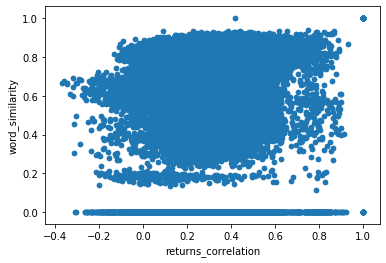

In [66]:
all_data.plot.scatter(x='returns_correlation', y='word_similarity')

## Part 4: Try to predict the future returns correlations
### Use OLS (`LinearRegression`) to predict `returns_correlation` from `word_similarity`. 
### What is the (contemperaneous) out of sample performance?

In [67]:
data_df = all_data
feature_cols = ['word_similarity']
target_col = ['returns_correlation']

In [68]:
# add code here

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = data_df[feature_cols]
y = data_df[target_col]
X_test, X_train, y_test, y_train = train_test_split(X, y,test_size = 0.2, random_state = 42 )
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.015278404359304833

In [69]:
pd.Series(reg.coef_[0], index=feature_cols)

word_similarity    0.079676
dtype: float64

### This is not amazing. We can do better!

## $ \\ $ 

## Part 5: Repeat, but be careful
### Here we will see if we can clean the data better

### Things to try
 - ### Look at the histograms of word similarities to see if we can "ignore" some ill-behaved data
 - ### Try limiting how greedy the `TFIDFVectorizer` is: `min_df`, `max_df`, `max_features`, etc.
 
### We will examine our data and look for things that look out of place
 - ### We will ultimately want our data to look normally distributed


In [95]:
def clean_mda(mda):
    paras = [p.lower() for p in mda.split('\n') if len(p) > 40]
    cleaned =  ' '.join(paras)
    words = cleaned.split()
    words = [word for word in words if len(word) > 2]
    if len(words) > 10:
        return ' '.join(words)
    else:
        return ''

In [96]:
vec = TfidfVectorizer(
    min_df= 1,
    max_df= 1000,
    max_features=10000 
    
)
word_vecs = vec.fit_transform([clean_mda(item['mda']) for item in data])

word_sims =  pd.DataFrame(cosine_similarity(word_vecs), columns = data_tickers, index = data_tickers)
# Lots of word similarities are all zeros- so we'll ignore
# add code here to remove rows of word_sims where all the elements are zero
word_sims = word_sims[(word_sims.T != 0).any()]
word_sims

,ADBE,AAP,AMD,AES,AMG,AFL,AIV,AKAM,SO,ALK,...,JCI,MU,RJF,ROK,SWKS,SBUX,SNPS,TSN,TDG,VIAB
ADBE,1.000000,0.726226,0.752448,0.691033,0.706894,0.605587,0.494687,0.833388,0.0,0.690847,...,0.695626,0.689096,0.748071,0.764579,0.828419,0.650211,0.838276,0.756551,0.735782,0.714168
AAP,0.726226,1.000000,0.757257,0.713525,0.714004,0.624554,0.507432,0.810033,0.0,0.709696,...,0.709819,0.697159,0.752869,0.789135,0.753085,0.714829,0.755677,0.738416,0.753761,0.719061
AMD,0.752448,0.757257,1.000000,0.760295,0.766375,0.641326,0.516049,0.821633,0.0,0.716964,...,0.792785,0.741325,0.781404,0.769769,0.809517,0.668754,0.804931,0.790490,0.792823,0.743380
AES,0.691033,0.713525,0.760295,1.000000,0.696567,0.652778,0.505597,0.795378,0.0,0.707894,...,0.806610,0.711003,0.778654,0.759761,0.747314,0.647072,0.748166,0.729584,0.793390,0.722795
AMG,0.706894,0.714004,0.766375,0.696567,1.000000,0.602751,0.502895,0.801854,0.0,0.683299,...,0.688093,0.676931,0.772442,0.739645,0.743684,0.624932,0.757091,0.732198,0.706342,0.701719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SBUX,0.650211,0.714829,0.668754,0.647072,0.624932,0.554777,0.447844,0.686348,0.0,0.610587,...,0.673411,0.607778,0.686977,0.676581,0.688641,1.000000,0.675882,0.681556,0.693328,0.647489
SNPS,0.838276,0.755677,0.804931,0.748166,0.757091,0.643306,0.509778,0.874216,0.0,0.731491,...,0.770275,0.730700,0.799060,0.790691,0.842162,0.675882,1.000000,0.787929,0.796299,0.749740
TSN,0.756551,0.738416,0.790490,0.729584,0.732198,0.617206,0.495295,0.789991,0.0,0.699543,...,0.776740,0.714378,0.777243,0.763731,0.822359,0.681556,0.787929,1.000000,0.800869,0.716956
TDG,0.735782,0.753761,0.792823,0.793390,0.706342,0.682504,0.501663,0.815330,0.0,0.724604,...,0.877982,0.724616,0.856285,0.775687,0.788223,0.693328,0.796299,0.800869,1.000000,0.726719


In [107]:
# calculate the returns correlation and the cosine similarities as above
word_cor = word_sims.stack().to_frame()

all_data = rets_cor.join(word_cor, lsuffix='_rets_cor', rsuffix='_word_sim')
all_data = all_data.dropna()
all_data.columns = ['returns_correlation', 'word_similarity']

Text(0.5, 1.0, 'Word Similarity')

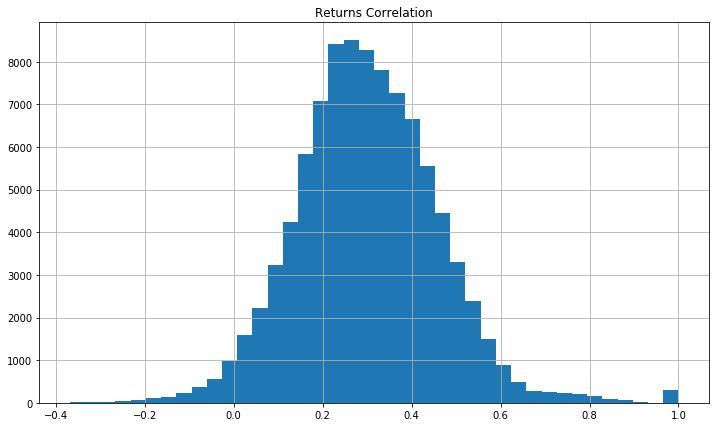

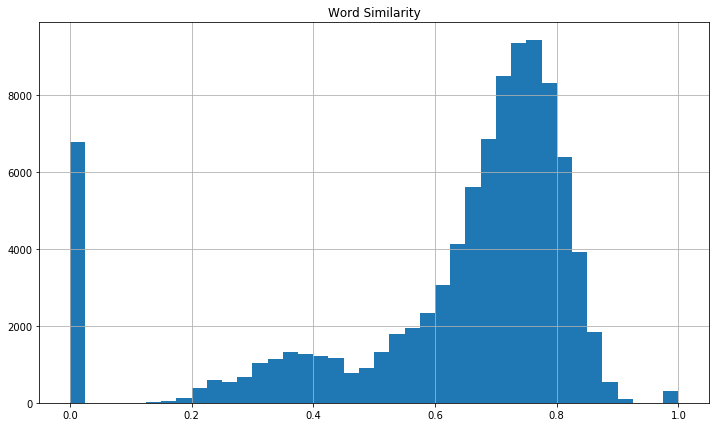

In [108]:
# inspect your data- make some histograms
plt.figure(figsize=(12,7))
all_data.returns_correlation.hist(bins=40)
plt.title('Returns Correlation')
plt.figure(figsize=(12,7))
all_data.word_similarity.hist(bins=40)
plt.title('Word Similarity')

### Cleaning our data
### It seems lots of things are identically 0 (no word overlap) or identically 1 (the MD&A section for one company perfectly overlaps itself). We will exclude those

In [109]:
all_data['word_similarity']

ACN  ACN     1.000000
     ADBE    0.756833
     AMD     0.733997
     AAP     0.708385
     AES     0.720879
               ...   
ZTS  XLNX    0.797136
     XYL     0.809144
     YUM     0.680219
     ZION    0.764895
     ZTS     1.000000
Name: word_similarity, Length: 93810, dtype: float64

In [110]:
# your code here
all_data = all_data[all_data['word_similarity']>0]
all_data = all_data[all_data['word_similarity']<1]

Text(0.5, 1.0, 'Word Similarity')

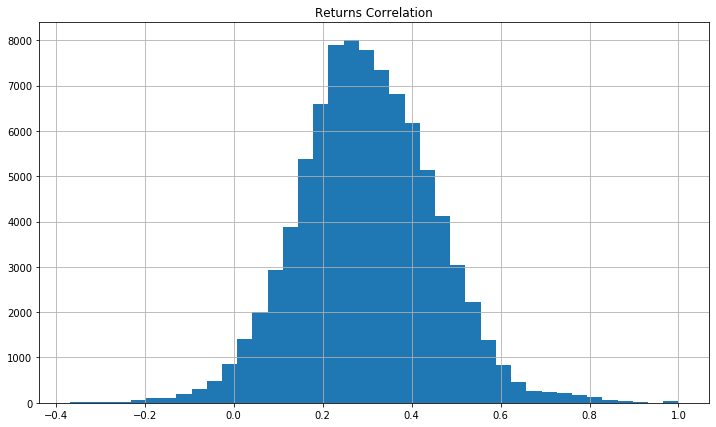

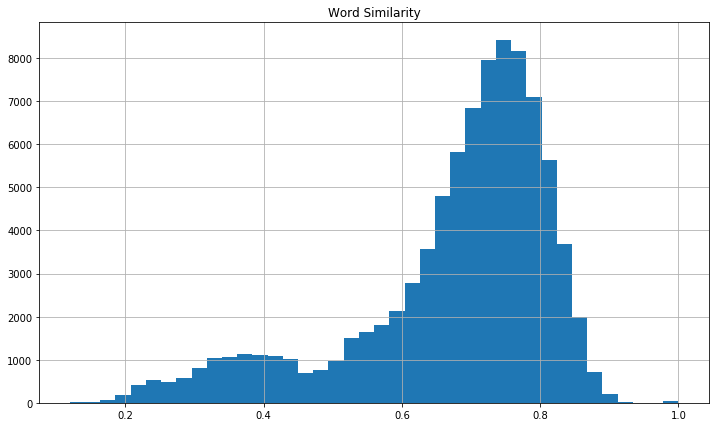

In [111]:
# examine histograms again
plt.figure(figsize=(12,7))
all_data.returns_correlation.hist(bins=40)
plt.title('Returns Correlation')
plt.figure(figsize=(12,7))
all_data.word_similarity.hist(bins=40)
plt.title('Word Similarity')

In [112]:
all_data.corr()

,returns_correlation,word_similarity
returns_correlation,1.00000,0.20617
word_similarity,0.20617,1.00000


### Lastly, there is a bit of a "hump" at low `word_similarity`

In [115]:
# add code here
# Not Sure what he wants? Remove the hump?
all_data = all_data[all_data['word_similarity']>0.5]
all_data.corr()

,returns_correlation,word_similarity
returns_correlation,1.000000,0.263148
word_similarity,0.263148,1.000000


### The contemperaneous correlation is twice as large!

## Part 6: Now, repeat the exercise of predicting future returns correlation

In [116]:
data_df =  all_data# Add code here
# add code here

In [117]:
feature_cols = ['word_similarity']
target_col = ['returns_correlation']
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = data_df[feature_cols]
y = data_df[target_col]
X_test, X_train, y_test, y_train = train_test_split(X, y,test_size = 0.2, random_state = 42 )
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)


0.06925948869133214

In [118]:
pd.Series(reg.coef_[0], index=feature_cols)

word_similarity    0.469537
dtype: float64

### This is about 5 times better than before!
## $ \\ $ 
## Part 7: What will happen if we include last year's returns correlation as a feature

In [92]:
last_year_corr =  prices.loc['2016-01-01':'2018-01-01'].pct_change().corr().stack().to_frame()
data_df = last_year_corr.join(word_cor, lsuffix='_rets_cor', rsuffix='_word_sim')
data_df = data_df.dropna()
data_df.columns = ['returns_correlation', 'word_similarity']
data_df = data_df[data_df['word_similarity']>0.5]
data_df = data_df[data_df['word_similarity']<1]

In [93]:
feature_cols = ['word_similarity']
target_col = ['returns_correlation']
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = data_df[feature_cols]
y = data_df[target_col]
X_test, X_train, y_test, y_train = train_test_split(X, y,test_size = 0.2, random_state = 42 )
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.06708750612712411

In [94]:
pd.Series(reg.coef_[0], index=feature_cols)

word_similarity    0.416222
dtype: float64

## Indeed, we do much better, but the word features still help!